# Visualization of the uncertainty maps

In [21]:
from pathlib import Path
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from dicom_utils import resample_to_reference
from uncertainty_quantification import apply_percentile_threshold

vsharp_reader_study_root = Path('/scratch/hb-pca-rad/projects/03_reader_set_v2')

# vSHARP Reconstruction Root Directories
acc_roots = {
    3: Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_{3}x"),
    6: Path(f"/scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_{6}x")
}

# Location where the .h5 kspace files are stored for each patient
kspace_root_dir = Path('/scratch/p290820/datasets/003_umcg_pst_ksps')      # source_dir

# Databases 
db_fpath_old = Path('/scratch/p290820/datasets/003_umcg_pst_ksps/database/dbs/master_habrok_20231106_v2.db')               # References an OLDER version of the databases where the info could also just be fine that we are looking for
db_fpath_new = Path('/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/databases/master_habrok_20231106_v2.db') # References the LATEST version of the databases where the info could also just be fine that we are looking for

# Parameters
debug                = True
do_adaptive_clipping = True
acc_factors          = [3, 6] # Define the set of acceleration factors we care about.
decimals             = 4         # Number of decimals to round to

# All patient IDs to consider for Uncertainty Quantification
pat_ids = [
        # '0003_ANON5046358',
        # '0004_ANON9616598',
        # '0005_ANON8290811',
        # '0006_ANON2379607',
        '0007_ANON1586301',
        # '0008_ANON8890538',
        # '0010_ANON7748752',
        # '0011_ANON1102778',
        # '0012_ANON4982869',
        # '0013_ANON7362087',
        # '0014_ANON3951049',
        # '0015_ANON9844606',
        # '0018_ANON9843837',
        # '0019_ANON7657657',
        # '0020_ANON1562419',
        # '0021_ANON4277586',
        # '0023_ANON6964611',
        # '0024_ANON7992094',
        # '0026_ANON3620419',
        # '0027_ANON9724912',
        # '0028_ANON3394777',
        # '0029_ANON7189994',
        # '0030_ANON3397001',
        # '0031_ANON9141039',
        # '0032_ANON7649583',
        # '0033_ANON9728185',
        # '0035_ANON3474225',
        # '0036_ANON0282755',
        # '0037_ANON0369080',
        # '0039_ANON0604912',
        # '0042_ANON9423619',
        # '0043_ANON7041133',
        # '0044_ANON8232550',
        # '0045_ANON2563804',
        # '0047_ANON3613611',
        # '0048_ANON6365688',
        # '0049_ANON9783006',
        # '0051_ANON1327674',
        # '0052_ANON9710044',
        # '0053_ANON5517301',
        # '0055_ANON3357872',
        # '0056_ANON2124757',
        # '0057_ANON1070291',
        # '0058_ANON9719981',
        # '0059_ANON7955208',
        # '0061_ANON7642254',
        # '0062_ANON0319974',
        # '0063_ANON9972960',
        # '0064_ANON0282398',
        # '0067_ANON0913099',
        # '0068_ANON7978458',
        # '0069_ANON9840567',
        # '0070_ANON5223499',
        # '0071_ANON9806291',
        # '0073_ANON5954143',
        # '0075_ANON5895496',
        # '0076_ANON3983890',
        # '0077_ANON8634437',
        # '0078_ANON6883869',
        # '0079_ANON8828023',
        # '0080_ANON4499321',
        # '0081_ANON9763928',
        # '0082_ANON6073234',
        # '0083_ANON9898497',
        # '0084_ANON6141178',
        # '0085_ANON4535412',
        # '0086_ANON8511628',
        # '0087_ANON9534873',
        # '0088_ANON9892116',
        # '0089_ANON9786899',
        # '0090_ANON0891692',
        # '0092_ANON9941969',
        # '0093_ANON9728761',
        # '0094_ANON8024204',
        # '0095_ANON4189062',
        # '0097_ANON5642073',
        # '0103_ANON8583296',
        # '0104_ANON7748630',
        # '0105_ANON9883201',
        # '0107_ANON4035085',
        # '0108_ANON0424679',
        # '0109_ANON9816976',
        # '0110_ANON8266491',
        # '0111_ANON9310466',
        # '0112_ANON3210850',
        # '0113_ANON9665113',
        # '0115_ANON0400743',
        # '0116_ANON9223478',
        # '0118_ANON7141024',
        # '0119_ANON3865800',
        # '0120_ANON7275574',
        # '0121_ANON9629161',
        # '0123_ANON7265874',
        # '0124_ANON8610762',
        # '0125_ANON0272089',
        # '0126_ANON4747182',
        # '0127_ANON8023509',
        # '0128_ANON8627051',
        # '0129_ANON5344332',
        # '0135_ANON9879440',
        # '0136_ANON8096961',
        # '0137_ANON8035619',
        # '0138_ANON1747790',
        # '0139_ANON2666319',
        # '0140_ANON0899488',
        # '0141_ANON8018038',
        # '0142_ANON7090827',
        # '0143_ANON9752849',
        # '0144_ANON2255419',
        # '0145_ANON0335209',
        # '0146_ANON7414571',
        # '0148_ANON9604223',
        # '0149_ANON4712664',
        # '0150_ANON5824292',
        # '0152_ANON2411221',
        # '0153_ANON5958718',
        # '0155_ANON7828652',
        # '0157_ANON9873056',
        # '0159_ANON9720717',
        # '0160_ANON3504149'
    ]

## So what do we want to see?

The goals is to see if the uncertainty map is correlated with the absoluate error map.
Especially in lesion locations.

We will first explore the following figure:
```
| R1         |      R3      |      R6      |

| R1 lesions | Abs Error R3 | Abs Error R6 |

|            |   UQ map R3  |   UQ map R6  |

|            |   UQ thr R3  |   UQ thr R6  |
```


R=1: /scratch/hb-pca-rad/projects/03_reader_set_v2/0007_ANON1586301/0007_ANON1586301_rss_target_dcml.mha,
shape: (33, 640, 640), min: 0.0, max: 1000.0
Lesion files: [PosixPath('/scratch/hb-pca-rad/projects/03_reader_set_v2/0007_ANON1586301/0007_ANON1586301_roi_2_1.mha'), PosixPath('/scratch/hb-pca-rad/projects/03_reader_set_v2/0007_ANON1586301/0007_ANON1586301_roi_1_2.mha')]
Loading /scratch/hb-pca-rad/projects/03_reader_set_v2/0007_ANON1586301/0007_ANON1586301_roi_2_1.mha
Loading /scratch/hb-pca-rad/projects/03_reader_set_v2/0007_ANON1586301/0007_ANON1586301_roi_1_2.mha
Lesion slices: [ 8  9 10]
R=3: /scratch/hb-pca-rad/projects/03_reader_set_v2/0007_ANON1586301/0007_ANON1586301_VSharp_R3_recon_dcml.mha,
shape: (33, 640, 640), min: 0.0, max: 1000.0
R=3 absolute error: min: 0.0, max: 260.0
R=3 UQ map: /scratch/hb-pca-rad/projects/04_uncertainty_quantification/gaussian/recons_3x/0007_ANON1586301/uq_map_R3_gm25.nii.gz,
shape: (33, 640, 640), min: 0.0, max: 0.004399999976158142
Applying p

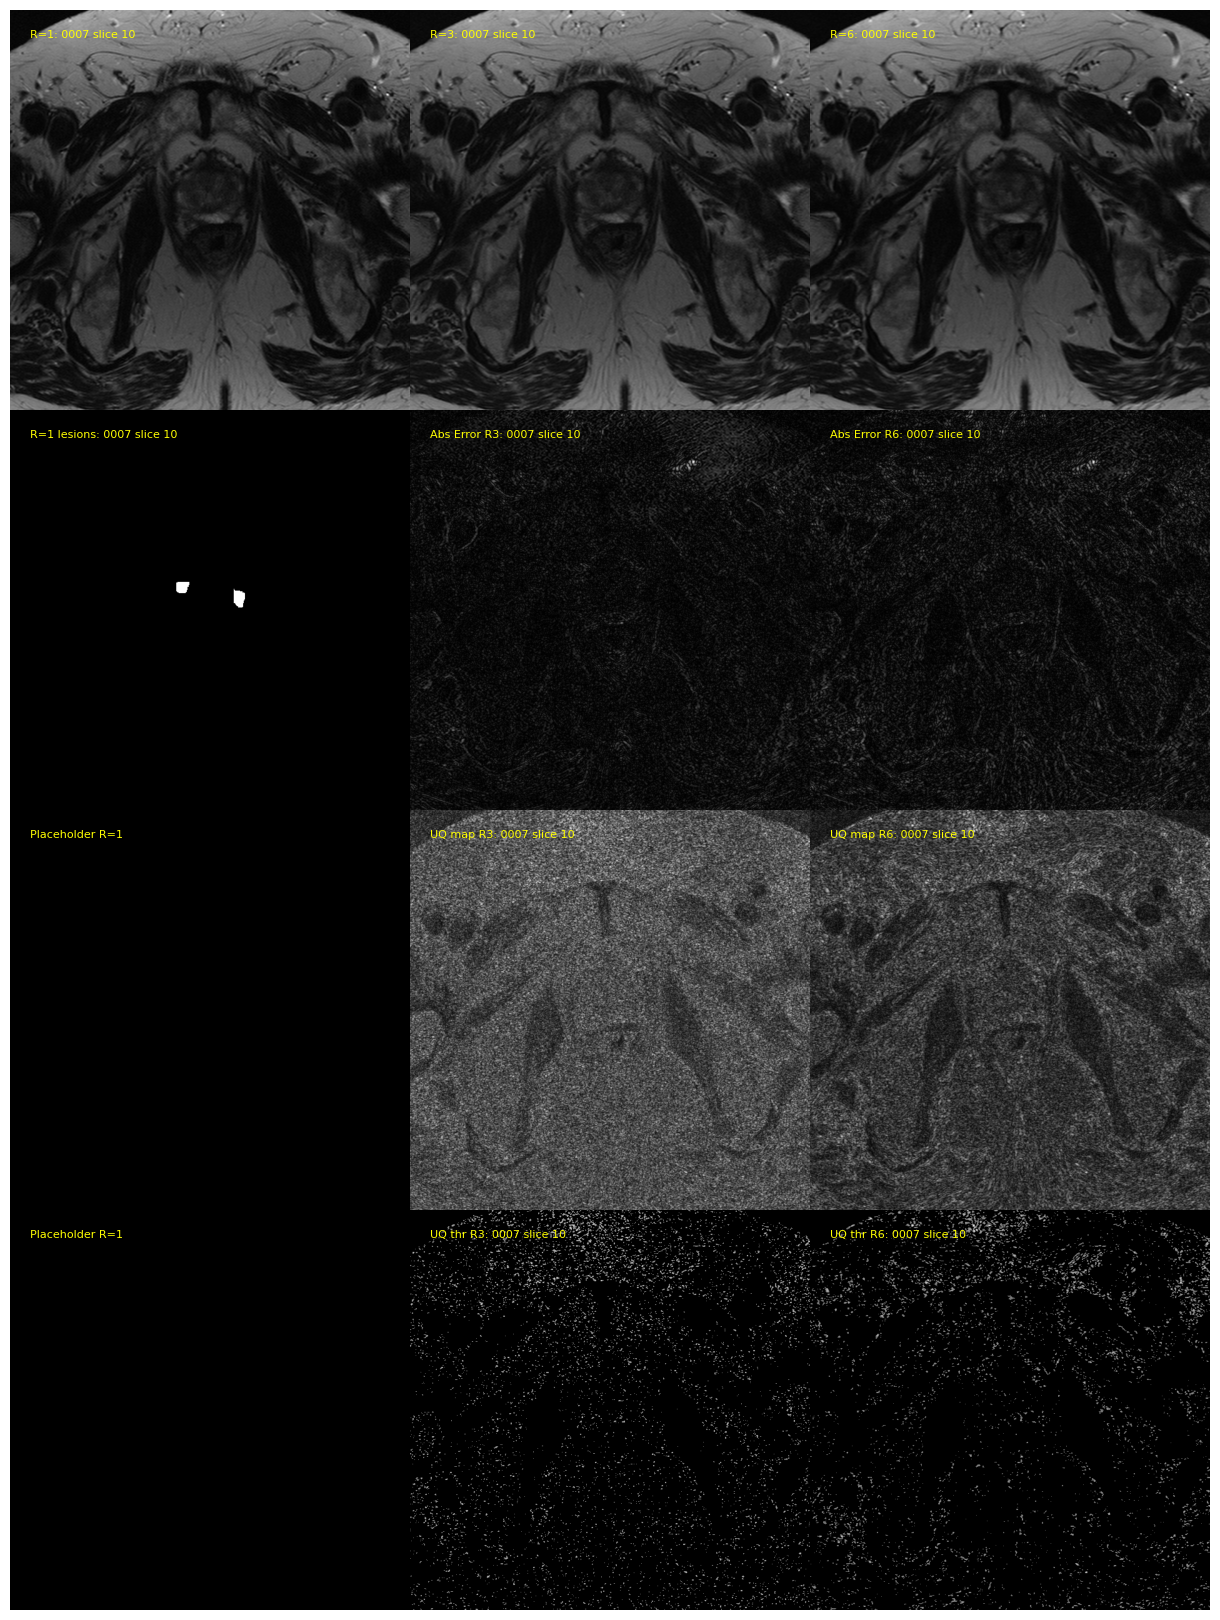

Figure saved to /home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/figures/UQ_vs_ABS_0007_ANON1586301_slice_10_R1_R3_R6.png


In [ ]:
def get_combined_rois_array(pat_root: Path, r1_ref_image: sitk.Image) -> np.ndarray:
    roi_fpaths = list(pat_root.glob("*_roi_*.mha"))
    print(f"Lesion files: {roi_fpaths}")
    roi_arrs = []       # list of 3d images
    for roi_fpath in roi_fpaths:
        print(f"Loading {roi_fpath}")
        # read 
        roi_img = sitk.ReadImage(str(roi_fpath))
        # resample to R=1
        roi_img_resampled = resample_to_reference(roi_img, r1_ref_image)
        # Convert to numpy array
        roi_arr_resampled = sitk.GetArrayFromImage(roi_img_resampled)
        roi_arrs.append(roi_arr_resampled)
    # combine all lesions into one array
    roi_arrs_combined = np.zeros_like(r1_arr)
    for roi_arr in roi_arrs:
        roi_arrs_combined += roi_arr

    # print which slices have lesions
    print(f"Lesion slices: {np.unique(np.where(roi_arrs_combined > 0)[0])}")

    return roi_arrs_combined



########################################### MAIN ###########################################
# We are going to make a matplotlib image grid 3x4

pat_id    = '0007_ANON1586301'   # Patient to consider:
slice_idx = 10
pat_root  = vsharp_reader_study_root / pat_id
perc_thr  = 95


# COLUMN 0:
##1. load R=1
r1_fpath = pat_root / f"{pat_id}_rss_target_dcml.mha"
r1_img   = sitk.ReadImage(str(r1_fpath))
r1_arr   = sitk.GetArrayFromImage(r1_img) # print shape, min max rounded
print(f"R=1: {r1_fpath},\nshape: {r1_arr.shape}, min: {np.round(np.min(r1_arr), decimals)}, max: {np.round(np.max(r1_arr), decimals)}")
##2. Load R=1 and the lesions in it, lets load the lesions
roi_arr = get_combined_rois_array(pat_root, r1_img)
##3. Empty
r1_empty_arr = np.zeros_like(r1_arr)
##4. Empty
## same as above


# Column 1
##1. Load R=3
r3_fpath = pat_root / f"{pat_id}_VSharp_R3_recon_dcml.mha"
r3_arr   = sitk.GetArrayFromImage(sitk.ReadImage(str(r3_fpath)))
print(f"R=3: {r3_fpath},\nshape: {r3_arr.shape}, min: {np.round(np.min(r3_arr), decimals)}, max: {np.round(np.max(r3_arr), decimals)}")
##2. Load R=3 absolute error
r3_abs_error_arr = np.abs(r1_arr - r3_arr)
print(f"R=3 absolute error: min: {np.round(np.min(r3_abs_error_arr), decimals)}, max: {np.round(np.max(r3_abs_error_arr), decimals)}")
##3. Load R=3 Uncertainty map
r3_uq_map_fpath = acc_roots[3] / pat_id / f"uq_map_R3_gm25.nii.gz"
r3_uq_map_arr   = sitk.GetArrayFromImage(sitk.ReadImage(str(r3_uq_map_fpath)))
print(f"R=3 UQ map: {r3_uq_map_fpath},\nshape: {r3_uq_map_arr.shape}, min: {np.round(np.min(r3_uq_map_arr), decimals)}, max: {np.round(np.max(r3_uq_map_arr), decimals)}")
##4. Load R=3 Uncertainty map thresholded
r3_uq_thr = apply_percentile_threshold(r3_uq_map_arr, percentile=perc_thr, debug=True)
print(f"R=3 UQ map thresholded: min: {np.round(np.min(r3_uq_thr), decimals)}, max: {np.round(np.max(r3_uq_thr), decimals)}")


# Column 2
##1. Load R=6
r6_fpath = vsharp_reader_study_root / pat_id / f"{pat_id}_VSharp_R6_recon_dcml.mha"
r6_img   = sitk.ReadImage(str(r6_fpath))
r6_arr   = sitk.GetArrayFromImage(r6_img) # print shape, min max rounded
print(f"R=6: {r6_fpath},\nshape: {r6_arr.shape}, min: {np.round(np.min(r6_arr), decimals)}, max: {np.round(np.max(r6_arr), decimals)}")
##2. Load R=6 absolute error
r6_abs_error_arr = np.abs(r1_arr - r6_arr)
print(f"R=6 absolute error: min: {np.round(np.min(r6_abs_error_arr), decimals)}, max: {np.round(np.max(r6_abs_error_arr), decimals)}")
##3. Load R=6 Uncertainty map
r6_uq_map_fpath = acc_roots[6] / pat_id / f"uq_map_R6_gm25.nii.gz"
r6_uq_map_img   = sitk.ReadImage(str(r6_uq_map_fpath))
r6_uq_map_arr   = sitk.GetArrayFromImage(r6_uq_map_img) # print shape, min max rounded
print(f"R=6 UQ map: {r6_uq_map_fpath},\nshape: {r6_uq_map_arr.shape}, min: {np.round(np.min(r6_uq_map_arr), decimals)}, max: {np.round(np.max(r6_uq_map_arr), decimals)}")
##4. Load R=6 Uncertainty map thresholded
r6_uq_thr = apply_percentile_threshold(r6_uq_map_arr, percentile=perc_thr, debug=True)
print(f"R=6 UQ map thresholded: min: {np.round(np.min(r6_uq_thr), decimals)}, max: {np.round(np.max(r6_uq_thr), decimals)}")


####################################### PLOTTING #######################################
# THE GRID
# | R1         |      R3      |      R6      |
# | R1 lesions | Abs Error R3 | Abs Error R6 |
# |            |   UQ map R3  |   UQ map R6  |
# |            |   UQ thr R3  |   UQ thr R6  |
seq_id = pat_id.split('_')[0]
# fig, axs = plt.subplots(4, 3, figsize=(15, 5))
# fig, axs = plt.subplots(4, 3, figsize=(6, 10))
# fig, axs = plt.subplots(4, 3, figsize=(6, 8))
fig, axs = plt.subplots(4, 3, figsize=(12, 16))


# ----------------- Column 1: R=1 data -----------------
# Row 0: R=1
axs[0, 0].imshow(r1_arr[slice_idx], cmap='gray')
axs[0, 0].axis('off')
axs[0, 0].text(
    0.05, 0.95,
    f"R=1: {seq_id} slice {slice_idx}",
    color='yellow', fontsize=8,
    transform=axs[0, 0].transAxes, va='top'
)

# Row 1: R=1 lesions
axs[1, 0].imshow(roi_arr[slice_idx], cmap='gray')
axs[1, 0].axis('off')
axs[1, 0].text(
    0.05, 0.95,
    f"R=1 lesions: {seq_id} slice {slice_idx}",
    color='yellow', fontsize=8,
    transform=axs[1, 0].transAxes, va='top'
)

# Row 2: R=1 placeholder
axs[2, 0].imshow(r1_empty_arr[slice_idx], cmap='gray')
axs[2, 0].axis('off')
axs[2, 0].text(
    0.05, 0.95,
    "Placeholder R=1",
    color='yellow', fontsize=8,
    transform=axs[2, 0].transAxes, va='top'
)

# Row 3: R=1 placeholder
axs[3, 0].imshow(r1_empty_arr[slice_idx], cmap='gray')
axs[3, 0].axis('off')
axs[3, 0].text(
    0.05, 0.95,
    "Placeholder R=1",
    color='yellow', fontsize=8,
    transform=axs[3, 0].transAxes, va='top'
)

# ----------------- Column 2: R=3 data -----------------
# Row 0: R=3
axs[0, 1].imshow(r3_arr[slice_idx], cmap='gray')
axs[0, 1].axis('off')
axs[0, 1].text(
    0.05, 0.95,
    f"R=3: {seq_id} slice {slice_idx}",
    color='yellow', fontsize=8,
    transform=axs[0, 1].transAxes, va='top'
)

# Row 1: R=3 absolute error
axs[1, 1].imshow(r3_abs_error_arr[slice_idx], cmap='gray')
axs[1, 1].axis('off')
axs[1, 1].text(
    0.05, 0.95,
    f"Abs Error R3: {seq_id} slice {slice_idx}",
    color='yellow', fontsize=8,
    transform=axs[1, 1].transAxes, va='top'
)

# Row 2: R=3 UQ map
axs[2, 1].imshow(r3_uq_map_arr[slice_idx], cmap='gray')
axs[2, 1].axis('off')
axs[2, 1].text(
    0.05, 0.95,
    f"UQ map R3: {seq_id} slice {slice_idx}",
    color='yellow', fontsize=8,
    transform=axs[2, 1].transAxes, va='top'
)

# Row 3: R=3 UQ map thresholded
axs[3, 1].imshow(r3_uq_thr[slice_idx], cmap='gray')
axs[3, 1].axis('off')
axs[3, 1].text(
    0.05, 0.95,
    f"UQ thr R3 ({perc_thr}%): {seq_id} slice {slice_idx}",
    color='yellow', fontsize=8,
    transform=axs[3, 1].transAxes, va='top'
)

# ----------------- Column 3: R=6 data -----------------
# Row 0: R=6
axs[0, 2].imshow(r6_arr[slice_idx], cmap='gray')
axs[0, 2].axis('off')
axs[0, 2].text(
    0.05, 0.95,
    f"R=6: {seq_id} slice {slice_idx}",
    color='yellow', fontsize=8,
    transform=axs[0, 2].transAxes, va='top'
)

# Row 1: R=6 absolute error
axs[1, 2].imshow(r6_abs_error_arr[slice_idx], cmap='gray')
axs[1, 2].axis('off')
axs[1, 2].text(
    0.05, 0.95,
    f"Abs Error R6: {seq_id} slice {slice_idx}",
    color='yellow', fontsize=8,
    transform=axs[1, 2].transAxes, va='top'
)

# Row 2: R=6 UQ map
axs[2, 2].imshow(r6_uq_map_arr[slice_idx], cmap='gray')
axs[2, 2].axis('off')
axs[2, 2].text(
    0.05, 0.95,
    f"UQ map R6: {seq_id} slice {slice_idx}",
    color='yellow', fontsize=8,
    transform=axs[2, 2].transAxes, va='top'
)

# Row 3: R=6 UQ map thresholded
axs[3, 2].imshow(r6_uq_thr[slice_idx], cmap='gray')
axs[3, 2].axis('off')
axs[3, 2].text(
    0.05, 0.95,
    f"UQ thr R6 ({perc_thr}%): {seq_id} slice {slice_idx}",
    color='yellow', fontsize=8,
    transform=axs[3, 2].transAxes, va='top'
)

# Remove spacing between subplots
plt.tight_layout(pad=0)
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, top=1, bottom=0)

# Show the figure
plt.show()

# Save the figure to /figures/
fig_dir = Path('/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/figures')
fig_dir.mkdir(parents=True, exist_ok=True)
fig_fpath = fig_dir / f"UQ_vs_ABS_{pat_id}_slice_{slice_idx}_R1_R3_R6.png"
fig.savefig(fig_fpath, bbox_inches='tight', pad_inches=0)
print(f"Figure saved to {fig_fpath}")
plt.close(fig)